# Getting Started on LLM Classification Fine Tuning with KerasNLP and Keras

In [1]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DebertaV2Tokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import math

/Users/whiteknight/Develop/kagglePractice/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config:
    RANDOM_SEED = 42
    MODEL_NAME = 'microsoft/deberta-v3-xsmall'
    BASE_PATH = './data'
    SEQUENCE_LENGTH = 512
    EPOCHS = 10
    BATCH_SIZE = 16
    SCHEDULER = 'cosine'
    ENCODING = 'utf-8'
    label2name = {0: "winner_model_a", 1: "winner_model_b", 2: "winner_tie"}
    name2label = {v:k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

In [3]:
# Detect device (Apple Silicon MPS or CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if torch.backends.mps.is_available():
        try:
            torch.mps.manual_seed(seed)  # May not be supported in all versions
        except:
            pass

In [5]:
set_seed(Config.RANDOM_SEED)

In [6]:
# Load Train Data
df = pd.read_csv(f'{Config.BASE_PATH}/train.csv')

# Sample data
# df = df.sample(frac=0.1)

# Take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: eval(x)[0])
df["response_a"] = df.response_a.map(lambda x: eval(x.replace("null", "''"))[0])
df["response_b"] = df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b", "winner_tie"]].idxmax(axis=1)
df["class_label"] = df.class_name.map(Config.name2label)

<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

In [7]:
# Load Test Data
test_df = pd.read_csv(f'{Config.BASE_PATH}/test.csv')

# Take the first prompt and response
test_df["prompt"] = test_df.prompt.map(lambda x: eval(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: eval(x.replace("null", "'"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: eval(x.replace("null", "'"))[0])

<string>:1: SyntaxWarning: invalid escape sequence '\/'


In [8]:
def make_pairs(row):
    row["encode_failed"] = False
    try:
        prompt = row.prompt.encode(Config.ENCODING).decode(Config.ENCODING)
    except:
        prompt = ""
        row["encode_fail"] = True
    
    try:
        response_a = row.response_a.encode(Config.ENCODING).decode(Config.ENCODING)
    except:
        response_a = ""
        row["encode_fail"] = True
    
    try:
        response_b = row.response_b.encode(Config.ENCODING).decode(Config.ENCODING)
    except:
        response_b = ""
        row["encode_fail"] = True
        
    row["options"]  = [
        f"Prompt: {prompt}\nResponse A: {response_a}",
        f"Response B: {response_b}",
    ]
    
    return row

In [9]:
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-xsmall")
model = AutoModel.from_pretrained("microsoft/deberta-v3-xsmall")

## Preprocessing
**What it does:** The preprocessor takes input strings and transform them into a dictionary( token_ids, padding_mask ) containing preprocessed tensors. This preprocess starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming "The quick brown fox" into ["the", "qu", "##ick", "br", "##own", "fox"], we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

In [ ]:

class LLMClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, is_test=False):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        try:
            prompt = row["prompt"].encode(Config.ENCODING).decode(Config.ENCODING)
        except:
            prompt = ""
        try:
            response_a = row["response_a"].encode(Config.ENCODING).decode(Config.ENCODING)
        except:
            response_a = ""
        try:
            response_b = row["response_b"].encode(Config.ENCODING).decode(Config.ENCODING)
        except:
            response_b = ""
            
        text_a = f"Prompt: {prompt}\n\nResponse A: {response_a}"
        text_b = f"Prompt: {prompt}\n\nResponse B: {response_b}"
        
        encoded_a = self.tokenizer(text_a, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        encoded_b = self.tokenizer(text_b, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        
        item = {
            "input_ids": torch.stack([encoded_a["input_ids"].squeeze(0), encoded_b["input_ids"].squeeze(0)]),
            "attention_mask": torch.stack([encoded_a["attention_mask"].squeeze(0), encoded_b["attention_mask"].squeeze(0)]),
        }
        
        # ✅ 明确只在 test=False 时加 label
        if not self.is_test and "class_label" in row:
            item["label"] = torch.tensor(int(row["class_label"]), dtype=torch.long)
        
        return item

In [11]:
# Train/valid split
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df["class_label"], random_state=Config.RANDOM_SEED)

# 构建 Dataset
datasets = {
    "train": LLMClassificationDataset(train_df, tokenizer, Config.SEQUENCE_LENGTH),
    "valid": LLMClassificationDataset(valid_df, tokenizer, Config.SEQUENCE_LENGTH),
    "test": LLMClassificationDataset(test_df, tokenizer, Config.SEQUENCE_LENGTH, is_test=True)
}

# 构建 Dataloader
dataloaders = {
    "train": DataLoader(
        LLMClassificationDataset(train_df, tokenizer, Config.SEQUENCE_LENGTH, is_test=False),
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,  # ✅ 避免 Apple Silicon 多进程报错
        pin_memory=True
    ),
    "valid": DataLoader(
        LLMClassificationDataset(valid_df, tokenizer, Config.SEQUENCE_LENGTH, is_test=False),
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    ),
    "test": DataLoader(
        LLMClassificationDataset(test_df, tokenizer, Config.SEQUENCE_LENGTH, is_test=True),
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
}

In [12]:
class DebertaClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super(DebertaClassifier, self).__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden_size = self.backbone.config.hidden_size
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.clasifier = nn.Sequential(
            nn.Linear(hidden_size * 2, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, input_ids, attention_mask):
        input_ids_a = input_ids[:, 0, :]
        input_ids_b = input_ids[:, 1, :]
        attention_mask_a = attention_mask[:, 0, :]
        attention_mask_b = attention_mask[:, 1, :]
        
        outputs_a = self.backbone(input_ids_a, attention_mask_a).last_hidden_state
        outputs_b = self.backbone(input_ids_b, attention_mask_b).last_hidden_state
        
        outputs_a = self.pooling(outputs_a.permute(0, 2, 1)).squeeze(-1)
        outputs_b = self.pooling(outputs_b.permute(0, 2, 1)).squeeze(-1)
        
        combined_outputs = torch.cat((outputs_a, outputs_b), dim=1)
        logits = self.clasifier(combined_outputs)
        return logits

In [13]:
def get_cosine_schedule_with_custom_warmup(optimizer, batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start = 1.0e-6
    lr_max = 0.6e-6 * batch_size
    lr_min = 1e-6
    lr_ramp_ep = 2
    lr_sus_ep = 0
    lr_decay = 0.8

    def lr_lambda(epoch):
        if epoch < lr_ramp_ep:
            return (lr_max - lr_start) / lr_ramp_ep * epoch / lr_max + lr_start / lr_max
        elif epoch < lr_ramp_ep + lr_sus_ep:
            return 1.0
        elif mode == 'exp':
            return ((lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min) / lr_max
        elif mode == 'step':
            return lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            return ((lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min) / lr_max
    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lr_lambda(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [14]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    val_logloss = log_loss(all_labels, all_preds, labels=Config.class_labels)
    return total_loss / len(dataloader), val_logloss

In [15]:
def fit(model, dataloaders, optimizer, scheduler, criterion, device):
    best_loss = float('inf')
    for epoch in tqdm(range(Config.EPOCHS)):
        print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
        train_loss = train_one_epoch(model, dataloaders["train"], optimizer, criterion, device)
        val_loss, val_logloss = eval_one_epoch(model, dataloaders["valid"], criterion, device)
        scheduler.step()

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val LogLoss: {val_logloss:.4f}")

        if val_logloss < best_loss:
            best_loss = val_logloss
            torch.save(model.state_dict(), "best_model.weights.pth")
            print(f"✅ Saved best model (log loss: {val_logloss:.4f})")

In [16]:
def fit(model, dataloaders, optimizer, scheduler, criterion, device):
    best_loss = float('inf')
    for epoch in tqdm(range(Config.EPOCHS)):
        print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
        train_loss = train_one_epoch(model, dataloaders["train"], optimizer, criterion, device)
        val_loss, val_logloss = eval_one_epoch(model, dataloaders["valid"], criterion, device)
        scheduler.step()

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val LogLoss: {val_logloss:.4f}")

        if val_logloss < best_loss:
            best_loss = val_logloss
            torch.save(model.state_dict(), "best_model.weights.pth")
            print(f"✅ Saved best model (log loss: {val_logloss:.4f})")

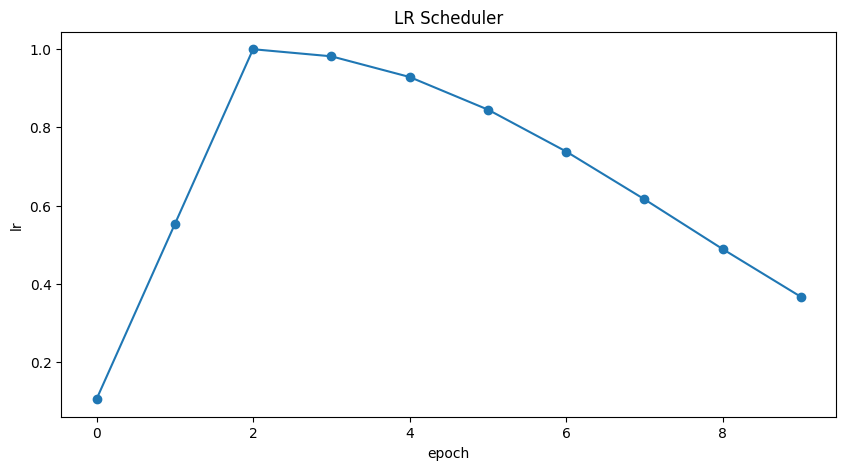

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10


  0%|          | 0/10 [00:00<?, ?it/s]


KeyError: 'label'

In [17]:
model = DebertaClassifier(Config.MODEL_NAME, num_classes=3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)
criterion = nn.CrossEntropyLoss(label_smoothing=0.02)
scheduler = get_cosine_schedule_with_custom_warmup(optimizer, batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, plot=True)

fit(model, dataloaders, optimizer, scheduler, criterion, device)

In [ ]:
# 推理并生成 submission.csv
def predict(model, dataloader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            all_probs.extend(probs)

    return np.array(all_probs)

# 加载最佳模型并预测
def generate_submission():
    model.load_state_dict(torch.load("best_model.weights.pth", map_location=device))
    model.to(device)
    test_preds = predict(model, dataloaders["test"], device)

    sub_df = test_df[["id"]].copy()
    sub_df[Config.class_names] = test_preds.tolist()
    sub_df.to_csv("submission.csv", index=False)
    print("✅ submission.csv saved!")
    return sub_df.head()

# 调用示例（训练完成后执行）
# generate_submission()

In [ ]:
generate_submission()